# Approximation to Friedman's five dimension function

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_experimental as pmx
from sklearn.model_selection import KFold
from scipy.special import expit

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

## Data generation

In [3]:
sin = np.loadtxt("space_influenza.csv", skiprows=1, delimiter=",")

X = sin[:,1][:,None]
Y = sin[:,2]
Y_jittered = np.random.normal(Y, 0.02)

In [4]:
idatas = {}
ms = ["10", "20", "50", "100", "200"]

for m in ms:
    with pm.Model() as model:
        μ = pmx.BART("μ", X, Y, m=int(m))
        p = pm.Deterministic("p", pm.math.sigmoid(μ))
        y = pm.Bernoulli("y", p=p, observed=Y)
        idata = pm.sample()

    idatas[m] = idata

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 370 seconds.


/home/osvaldo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, c

Text(-0.03, 0.5, 'Space Influenza')

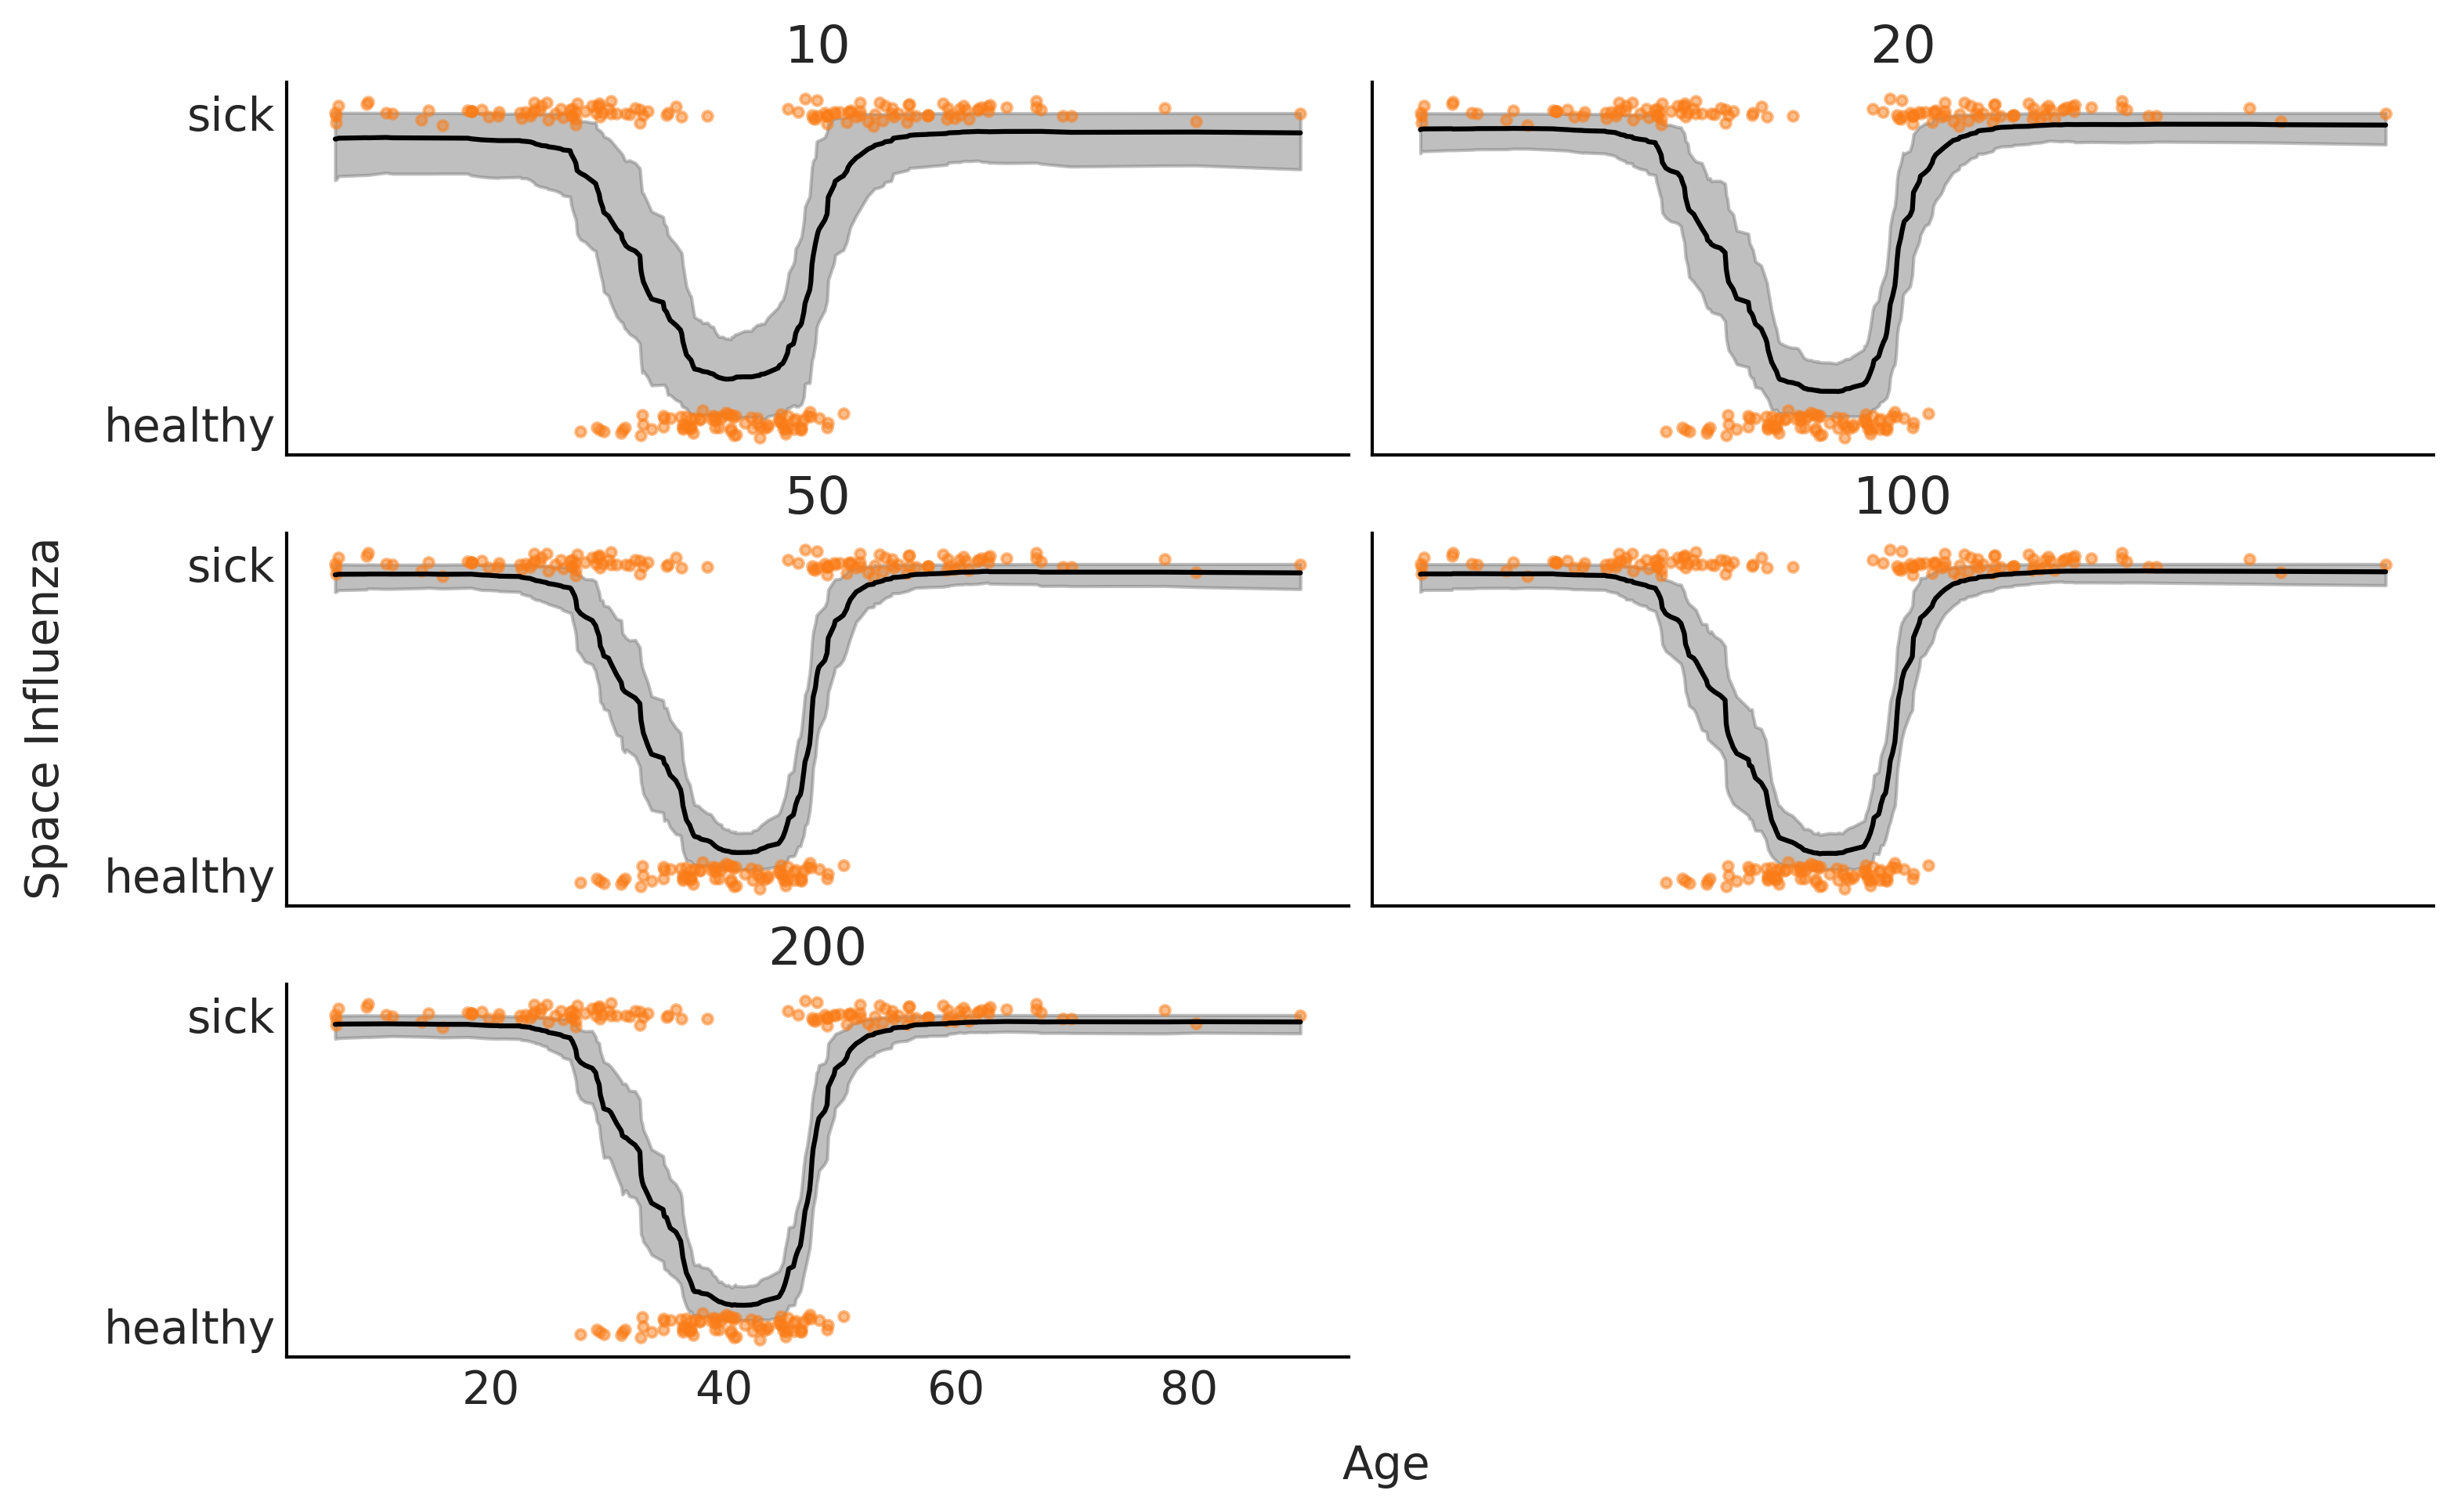

In [7]:
fig, axes = plt.subplots(3,2, figsize=(10, 6), sharey=True, sharex=True)

for ax, (m, idata) in zip(np.ravel(axes), idatas.items()):
    ps = idata.posterior["p"].stack({"draws":["chain",  "draw"]})

    ax.plot(X, Y_jittered, "C1.", alpha=0.5)

    X_idx = np.argsort(X[:,0])
    ax.plot(X[:,0][X_idx], np.mean(ps, 1)[X_idx], 'k-') 
    
    az.plot_hdi(X[:,0], ps.T, ax=ax, smooth=False, color="0.5") 
    ax.set_title(m)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["healthy", "sick"])
axes[2, 1].remove()
fig.text(0.55, -0.04, 'Age', ha='center', size=14)
fig.text(-0.03, 0.5, 'Space Influenza', va='center', size=14, rotation=90)

In [8]:
cmp = az.compare(idatas)
cmp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
200,0,-60.298513,3.481998,0.000000,1.0,6.283253,0.000000,False,log
100,1,-60.990396,3.857138,0.691883,0.0,6.302711,0.161599,False,log
50,2,-61.769868,4.412347,1.471355,0.0,6.283521,0.159227,False,log
20,3,-66.477944,6.127051,6.179431,0.0,6.117890,0.364759,False,log
10,4,-76.306779,11.220550,16.008266,0.0,6.115911,0.659613,False,log


<AxesSubplot:xlabel='Log'>

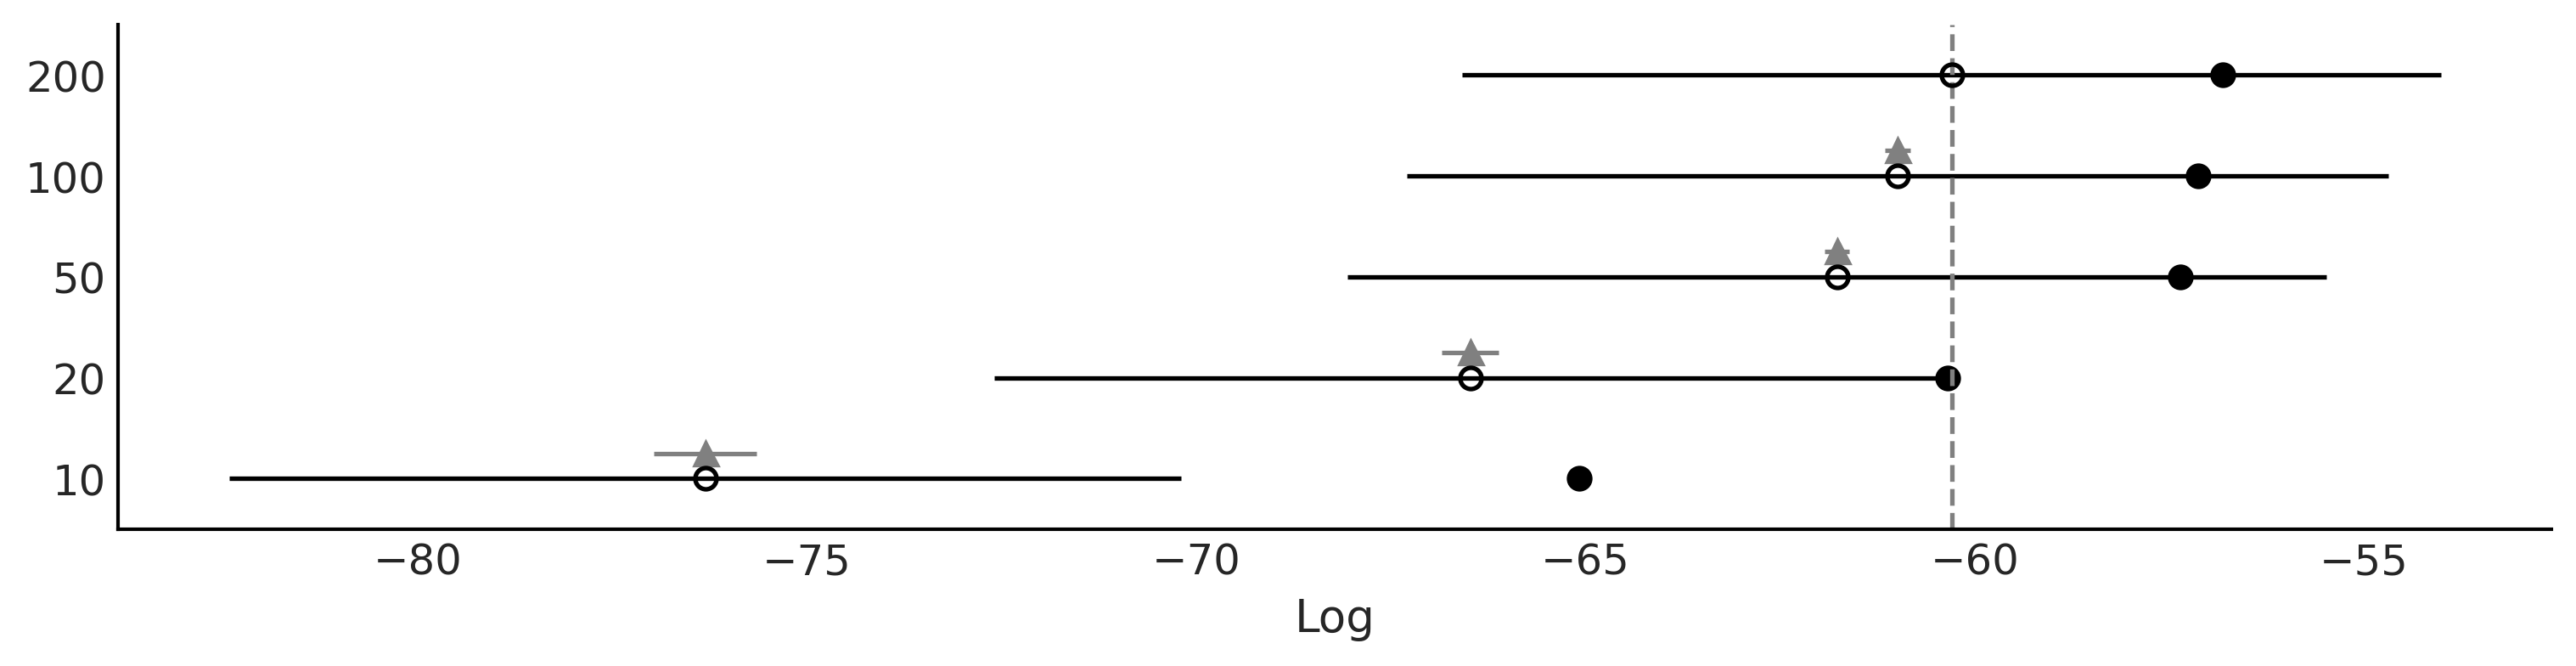

In [9]:
az.plot_compare(cmp, figsize=(10, 2.5))